--- 1. Loading and Exploring Data ---
Data loaded successfully.

First 5 rows of the dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1     

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:33:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Performance for XGBoost:
  Accuracy: 0.8490
  Precision: 0.6829
  Recall: 0.4816
  F1-Score: 0.5648
  ROC-AUC: 0.8328

--- 4. Visualizing Feature Importance ---


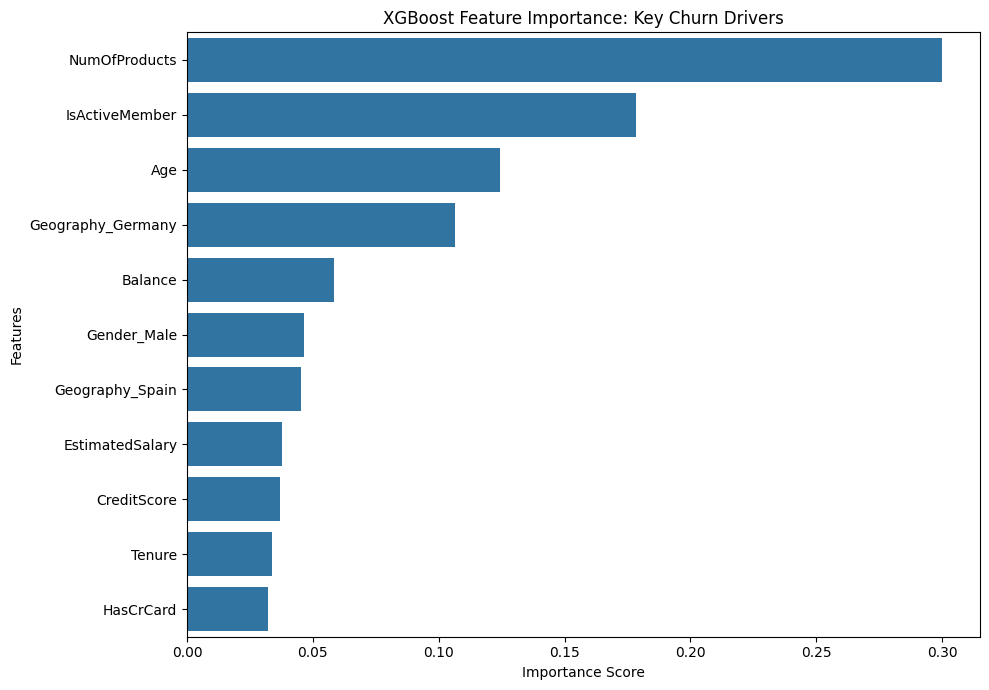

Feature importance chart displayed.

--- 5. Visualizing Confusion Matrix and Classification Report ---


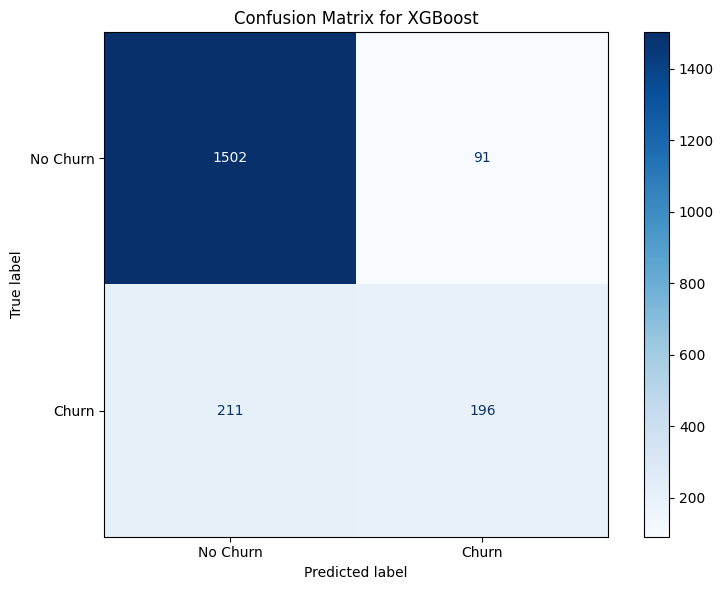

Confusion Matrix for XGBoost displayed.

Detailed Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.68      0.48      0.56       407

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000


--- 6. Churn Probability per Customer & Risk Segmentation ---

Sample of Customer Churn Probabilities and Risk Segments (from test set):
      Exited  Predicted_Churn_Probability  Predicted_Churn_Class Risk_Segment
5702       0                     0.020526                      0     Low Risk
3667       0                     0.010975                      0     Low Risk
1617       0                     0.011971                      0     Low Risk
5673       0                     0.018073                      0     Low Risk
4272       0                     0.026230                   

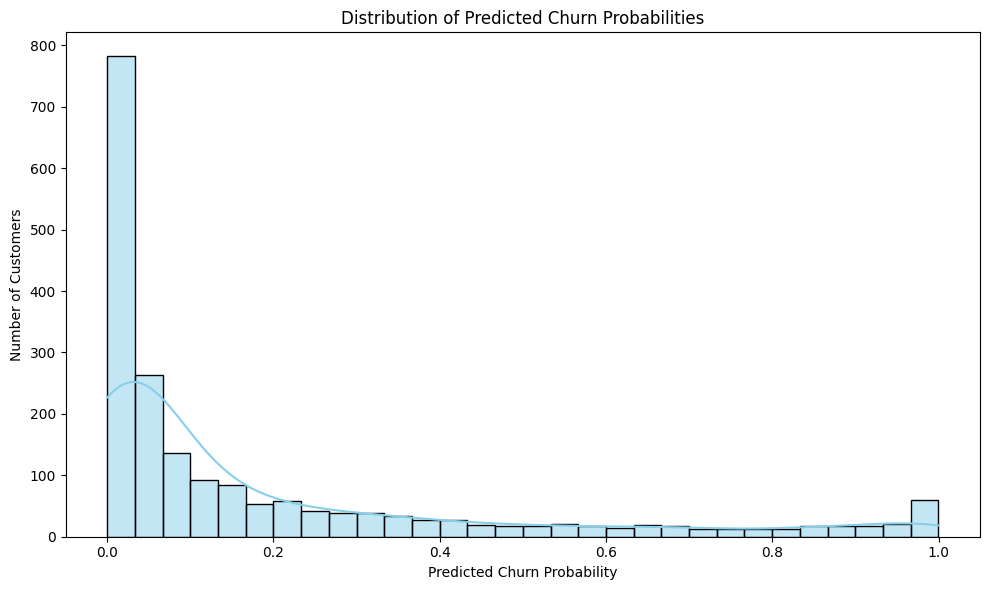

Distribution of churn probabilities displayed.

--- 7. Exporting Results to CSV for Power BI ---
Results exported to 'churn_prediction_results_for_powerbi.csv'. You can download this file from the Colab 'Files' section and import it into Power BI.
This CSV file contains customer features along with their 'Exited' status (actual churn), 'Predicted_Churn_Probability', 'Predicted_Churn_Class', and 'Risk_Segment'.


In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os

# --- 1. Data Loading and Initial Exploration ---
print("--- 1. Loading and Exploring Data ---")
# Make sure to upload 'Churn_Modelling.csv' to your Colab session files.
# You can do this by clicking the folder icon on the left sidebar, then the upload icon.
try:
    df = pd.read_csv('Churn_Modelling.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Churn_Modelling.csv' not found.")
    print("Please upload the file to your Colab environment by clicking the folder icon (Files) on the left sidebar, then the upload icon, and select 'Churn_Modelling.csv'.")
    # Exit the script if the file is not found
    exit()

print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
df.info()
print("\nDescriptive statistics:")
print(df.describe())

# --- 2. Data Preprocessing and Feature Engineering ---
print("\n--- 2. Preprocessing Data ---")
# Drop irrelevant columns: RowNumber, CustomerId, and Surname
# These columns are typically identifiers and not useful for prediction
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Check for missing values and handle them (if any)
if df.isnull().sum().any():
    print("\nMissing values detected. Handling by dropping rows with missing values...")
    df.dropna(inplace=True)
    print("Rows with missing values dropped.")

# One-Hot Encode categorical features
# 'Geography' and 'Gender' are nominal categorical features, so one-hot encoding is appropriate.
# 'drop_first=True' avoids multicollinearity.
categorical_cols = ['Geography', 'Gender']
df = pd.get_dummies(data=df, columns=categorical_cols, drop_first=True)

# Define features (X) and target (y)
X = df.drop(columns='Exited')  # 'Exited' is our target variable
y = df['Exited']

# Split data into training and testing sets
# We use stratify=y to ensure that the proportion of churned/non-churned customers is the same in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical columns for scaling
# Scaling is crucial for distance-based algorithms and can improve convergence for others.
# These are the original numerical columns, plus any numerical columns that resulted from one-hot encoding if not explicitly handled.
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()

# Scale numerical features in both training and testing sets
# fit_transform on train, transform on test to prevent data leakage
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nData preprocessing complete.")
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print("\nFirst 5 rows of preprocessed X_train (scaled numericals and one-hot encoded categoricals):")
print(X_train.head())

# --- 3. Model Training and Evaluation ---
print("\n--- 3. Training and Evaluating Models ---")
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42) # eval_metric for deprecation warning
}

# Dictionary to store results for later use (e.g., best model's predictions)
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'metrics': {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    }

    print(f"Performance for {name}:")
    for metric, value in results[name]['metrics'].items():
        print(f"  {metric}: {value:.4f}")

    # Optional: Print classification report for each model
    # print(f"\n  Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

# --- 4. Visualize Key Churn Drivers (Feature Importance) ---
print("\n--- 4. Visualizing Feature Importance ---")
# Tree-based models (Random Forest, XGBoost) provide feature importances.
# XGBoost generally provides good insights.
xgb_model = results['XGBoost']['model']
feature_importances = pd.DataFrame(
    {'feature': X.columns, 'importance': xgb_model.feature_importances_}
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importance: Key Churn Drivers')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print("Feature importance chart displayed.")

# --- 5. Confusion Matrix and Evaluation Metrics Visualization ---
print("\n--- 5. Visualizing Confusion Matrix and Classification Report ---")
# Using the XGBoost model for visualization as it's typically a strong performer
best_model_name = 'XGBoost'
y_pred_best = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title(f'Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()
print(f"Confusion Matrix for {best_model_name} displayed.")

print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))

# --- 6. Churn Probability per Customer & Risk Segmentation ---
print("\n--- 6. Churn Probability per Customer & Risk Segmentation ---")
# We'll use the XGBoost model's probabilities for this as well
churn_probabilities = results[best_model_name]['y_proba']

# Create a DataFrame to store actual churn, predicted probabilities, and predicted classes
# Align with the original X_test index if you want to map back to original data points
original_test_data = df.loc[X_test.index] # Get original data for test set customers
results_for_powerbi_df = original_test_data.copy()
results_for_powerbi_df['Predicted_Churn_Probability'] = churn_probabilities
results_for_powerbi_df['Predicted_Churn_Class'] = y_pred_best

# Define risk segments based on probability thresholds
def risk_segmentation(prob):
    if prob >= 0.75:
        return 'High Risk'
    elif prob >= 0.5:
        return 'Medium Risk'
    else:
        return 'Low Risk'

results_for_powerbi_df['Risk_Segment'] = results_for_powerbi_df['Predicted_Churn_Probability'].apply(risk_segmentation)

print("\nSample of Customer Churn Probabilities and Risk Segments (from test set):")
print(results_for_powerbi_df[['Exited', 'Predicted_Churn_Probability', 'Predicted_Churn_Class', 'Risk_Segment']].head(10))

# Visualize the distribution of churn probabilities
plt.figure(figsize=(10, 6))
sns.histplot(results_for_powerbi_df['Predicted_Churn_Probability'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Churn Probabilities')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()
print("Distribution of churn probabilities displayed.")

# --- 7. Export Results to CSV for Power BI ---
print("\n--- 7. Exporting Results to CSV for Power BI ---")
output_filename = 'churn_prediction_results_for_powerbi.csv'
# It's good practice to include all original features and the new prediction columns
results_for_powerbi_df.to_csv(output_filename, index=False)
print(f"Results exported to '{output_filename}'. You can download this file from the Colab 'Files' section and import it into Power BI.")
print("This CSV file contains customer features along with their 'Exited' status (actual churn), 'Predicted_Churn_Probability', 'Predicted_Churn_Class', and 'Risk_Segment'.")